# Hypothesis and Goals

Prev returns of stocks like (BTC, SOLANA, ETHEREUM) --> can be used to predict some shitty ass stocks

Reason

    - shitty stocks should to react to beta
    - but they react slowly, low liquidity


# Investigation

1. Find top correlated stock with Indicator stocks' prevTimerange returns
2. Bin by Indicator's prevTimerange returns --> see what corr stock's returns look like on avg.
    check in train data
    then test data should look similar
3. Backtest a strategy and view pnl

In [11]:
""" 
Imports
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [12]:
df = pd.read_csv('./5min_data.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df.head()
print("Daterange:", df.index[0], df.index[-1])

Daterange: 2024-09-01 00:00:00 2024-11-21 19:00:00


In [13]:
# Change time range
df = df.iloc[::1]

In [19]:
# Train range: September to October end
start_train  = datetime(2024, 9, 1)
end_train = datetime(2024, 10, 31)
end_test = datetime(2024, 11, 21, 19)
train_df = df.loc[start_train:end_train]
test_df = df.loc[end_train + timedelta(hours=1):end_test]

In [ ]:
def getReturnDf(data):
    temp = data.dropna(how='any', axis=1)

    # Get most stock returns
    stocks = [colName.split('_')[0] for colName in temp.columns]

    for stock in stocks:
        temp[f'{stock}_return'] = (temp[f'{stock}_close'] - temp[f'{stock}_close'].shift(1))/temp[f'{stock}_close'].shift(1)

    # Get indicator returns, shifted extra
    indicators = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
    for indicator in indicators:
        temp[f'{indicator}_prev_return'] = temp[f'{indicator}_return'].shift(1)

    return_df = temp.filter(regex='return$')
    return_df = return_df.drop(labels=return_df.index[:2], axis=0)
    return return_df

train_returns = getReturnDf(train_df)
test_returns = getReturnDf(test_df)

In [23]:
# Find most correlated with BTC return prev
topCorr = train_returns.corrwith(train_returns['ETHUSDT_prev_return'], axis=0).sort_values(ascending=False)
topCorr.head(30)

ETHUSDT_prev_return    1.000000
BTCUSDT_prev_return    0.860023
SOLUSDT_prev_return    0.792233
ETH-28MAR25_return     0.285404
ETH-27JUN25_return     0.271709
ETH-27DEC24_return     0.249063
ARBPERP_return         0.224918
OPPERP_return          0.217405
ETHFIPERP_return       0.217259
OSMOUSDT_return        0.216659
BTC-27JUN25_return     0.215389
AEVOPERP_return        0.213693
ETCPERP_return         0.210814
DEXEUSDT_return        0.208975
SHIB1000PERP_return    0.195054
MNTPERP_return         0.192626
BNBPERP_return         0.188976
STRKPERP_return        0.187118
BTC-28MAR25_return     0.183328
ORDIPERP_return        0.179408
ONDOPERP_return        0.175411
BTC-27DEC24_return     0.162246
WLDPERP_return         0.151710
ETHBTCUSDT_return      0.150196
DOGEPERP_return        0.150005
DGBUSDT_return         0.142501
XNOUSDT_return         0.140824
TONPERP_return         0.139944
GNOUSDT_return         0.135536
1000PEPEPERP_return    0.125511
dtype: float64

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_29118/2389716187.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{x}_binned'] = pd.cut(data[x]*100*100, bins=bins)
/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


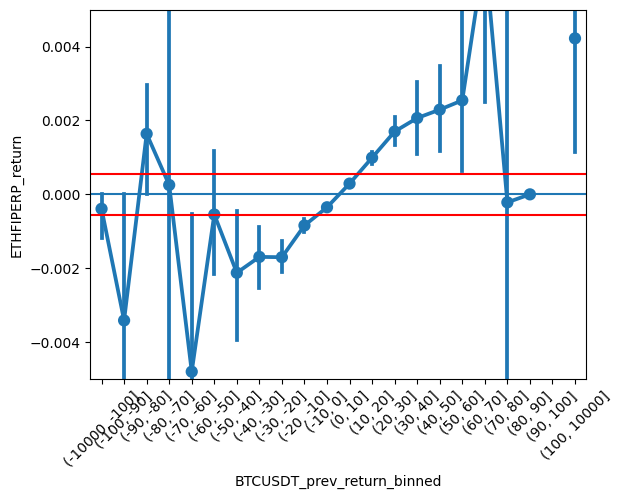

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_29118/2389716187.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{x}_binned'] = pd.cut(data[x]*100*100, bins=bins)
/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


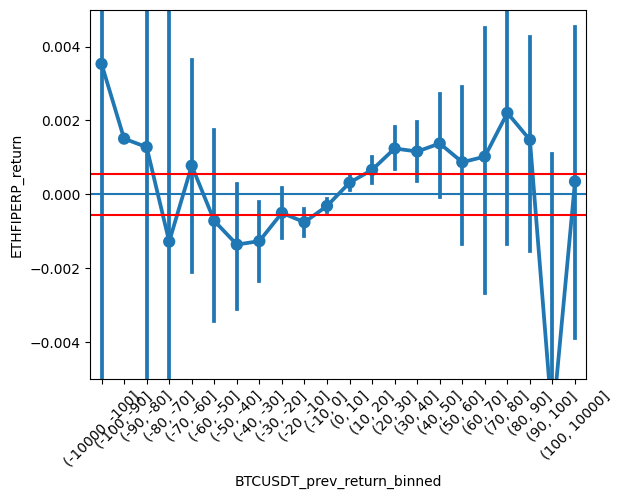

In [ ]:
import statsmodels.api as sm

def binnedReturnComparison(data, x, y):
    bins = [-10000] + list(np.arange(-100, 101, 10)) + [10000]
    
    data[f'{x}_binned'] = pd.cut(data[x]*100*100, bins=bins)
    # display(data[f'{x}_binned'].value_counts(normalize=True))

    sns.pointplot(data=data, x=f'{x}_binned', y=y)
    plt.xticks(rotation=45)
    plt.axhline(y=0)
    plt.axhline(y=0.00055, color='red')
    plt.axhline(y=-0.00055, color='red')
    plt.ylim(bottom=-0.005, top=0.005)
    plt.show()

    # model = sm.OLS(data[y], sm.add_constant(data[x])).fit()
    # print(model.summary())

    # sns.residplot(data=data, x=x, y=y)
    # plt.show()

stocks = ['ETHFIPERP_return', 'ARBPERP_return', 'OSMOUSDT_return', 'SHIB1000PERP_return']
binnedReturnComparison(train_returns, 'BTCUSDT_prev_return', stocks[0])
binnedReturnComparison(test_returns, 'BTCUSDT_prev_return', stocks[0])

# Findings

Fees wipe out a lot of profits, usually containing the [0-10] and [10-20] buckets

- ETHFIPERP looks promising, with only the [0-10] buckets contained in the fee line